# **Pendahuluan**

Dalam projek ini, kami bertujuan untuk membandingkan model machine learning regresi (Linear Regression, Random Forest Regression, KNN Regression, Support Vector Regression, ANN) untuk menemukan model machine learning terbaik untuk menentukan harga penutupan saham keesokkan hari, dengan melihat data open, close, high, low, volume, dan adj. Penentuan model terbaik akan ditentukan berdasarkan metric yang telah kami pilih yaitu RMSE, dan . Berikut adalah lagkah-langkah yang kami lakukan:


1. Data Loading
2. Data Visualization
3. Preprocessing
4. Data Splitting (train & test)
5. Model Visualization
6. Model Training
7. Model Evaluation

# **Importing Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

# **Data Loading**

In [2]:
df = pd.read_csv('NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


# **Data Visualization**

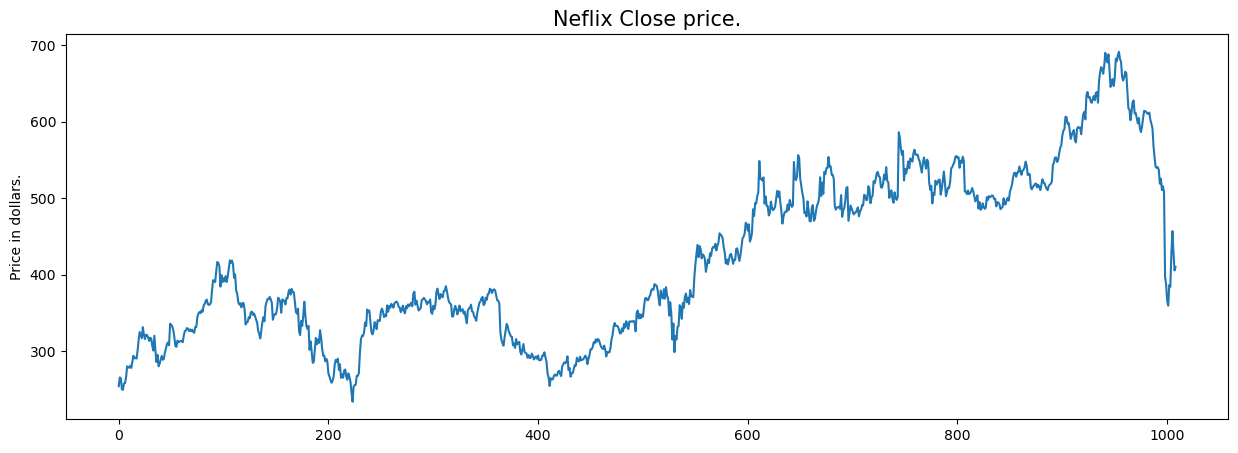

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Neflix Close price.', fontsize=15)
plt.ylabel('Price in dollars.')

plt.show()

C:\Users\elvin\AppData\Local\Temp\ipykernel_1168\4090406127.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
c:\Users\elvin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\elvin\AppData\Local\Temp\ipykernel_1168\4090406127.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `h

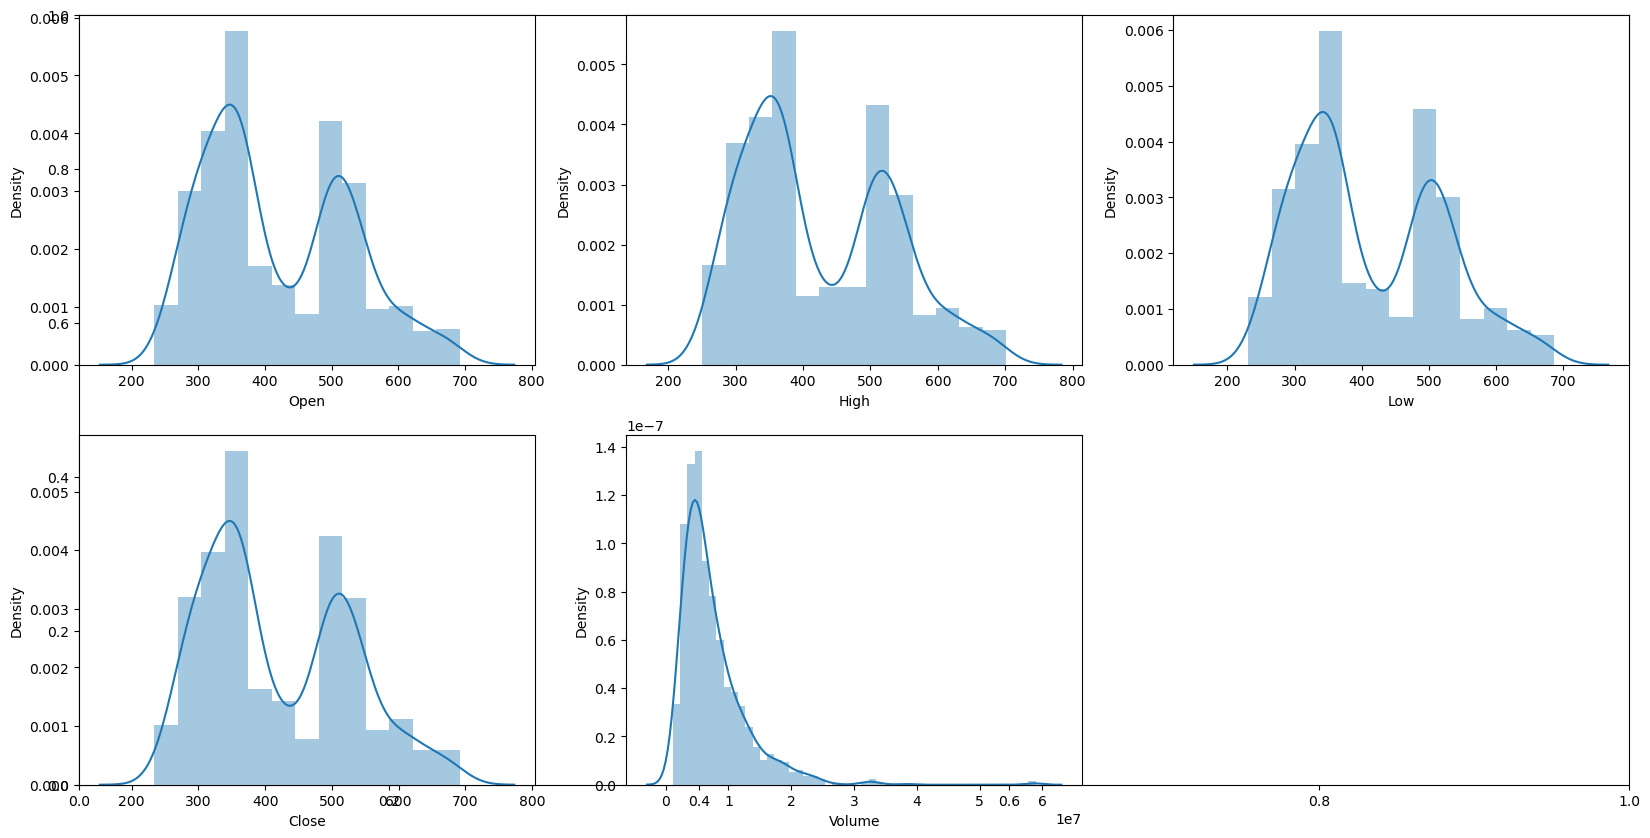

In [5]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.distplot(df[col])
plt.show()

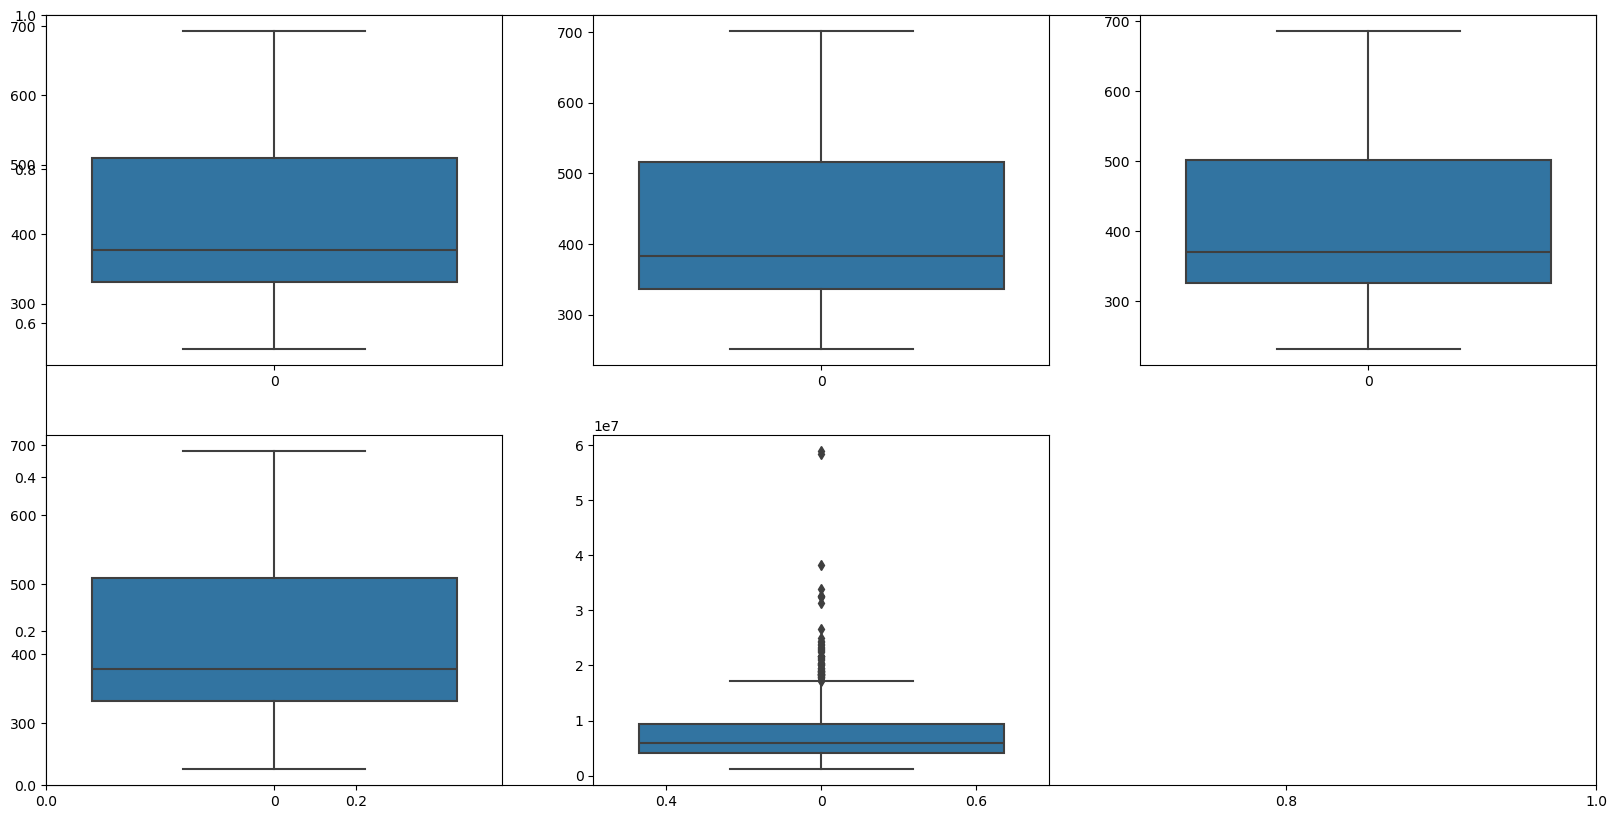

In [6]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sns.boxplot(df[col])
plt.show()

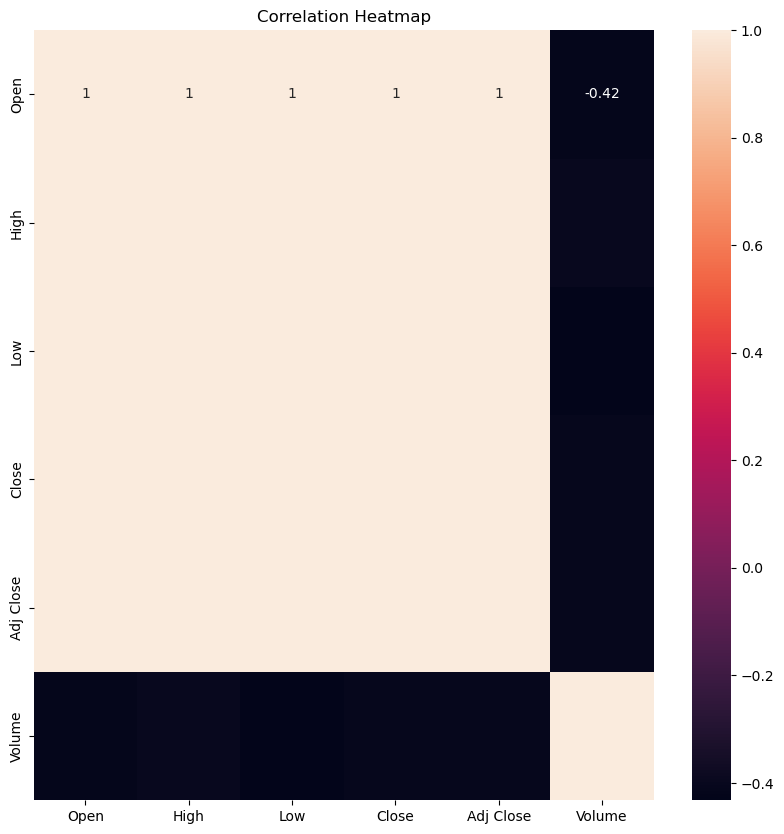

In [7]:
correlation_matrix = df.drop(columns=['Date']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cbar=True)
plt.title('Correlation Heatmap')
plt.show()

Pada histogram distribusi untuk setiap fitur, terlihat bahwa distribusi dari volume mengalami skewed yang mana artinya distribusi data cenderung memiliki lebih banyak nilai yang lebih tinggi dan lebih sedikit nilai yang lebih rendah. Ini juga dikenal sebagai distribusi yang "positif skewed" atau "right-skewed". Pada boxplot terlihat bahwa volume memiliki banyak data outlier pada data volume. Terlihat pada correlation heatmap, bahwa semua features kecuali volume, memiliki korelasi 1, yang mana berarti semua features tersebut memiliki korelasi yang sangat tinggi satu sama lain.

# **Data Preprocessing**

Pada bagian data preprocessing, kami melakukan pengecekan terhadap data yang NULL dan juga data yang duplikat. Tidak ditemukan data yang null dan yang duplikat, oleh sebab itu data tidak perlu dilakukan pengolahan. Namun Terlihat bahwa close dan adj close semuanya memiliki nilai yang sama maka kolom 'Adj Close' dapat di drop


In [8]:
# Cek apakah ada data yang NULL
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
# Cek apakah ada data yang duplicate
duplicates = df.duplicated()
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [10]:
# Karena data dari close dan adj close saya lihat sama maka feature adj close tidak digunakan
df[df['Close'] == df['Adj Close']].shape

(1009, 7)

In [11]:
df = df.drop(columns=['Adj Close'])
df = df.drop(columns=['Date'])
df = df.drop(columns=['Open'])
df = df.drop(columns=['High'])
df = df.drop(columns=['Low'])
df = df.drop(columns=['Volume'])
df.head()

,Close
0,254.259995
1,265.720001
2,264.559998
3,250.100006
4,249.470001


# **Sliding Window**



Pada projek ini kami melakukan sliding window untuk membuat subset data dari keseluruhan dataset berdasarkan jangka waktu mingguan (7 hari). Kami menggunakan data selama 7 hari ke belakang untuk menentukan harga penutupan keesokan harinya.

In [12]:
window_size = 10
def create_windowed_dataset(dataframe, window_size):
    X = []
    y = []
    for i in range(len(dataframe) - window_size):
        window = dataframe['Close'].iloc[i:i + window_size].values
        target = dataframe['Close'].iloc[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

X, y = create_windowed_dataset(df, window_size)

# **Model Initialization**

In [13]:
lr_model = LinearRegression()

# **Model Training**

In [14]:
lr_model.fit(X,y)

LinearRegression()

# **Model Evaluation**

In [15]:
def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['RMSE'] = np.sqrt(mean_squared_error(y_true, y_pred))
    metrics['MAPE'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    metrics['MBE'] = np.mean(y_pred - y_true)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['SMAPE'] = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    metrics['R²'] = r2_score(y_true, y_pred)
    return metrics

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.ylabel('Closing Price', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


[280.2565544  279.33059438 280.9036767  277.60274955 285.65488157
 294.42210459 292.01442714 293.13325321 291.02540753 300.12594766
 314.77231286 325.5362406  323.32734474 318.04667728 329.6997513
 320.5701975  315.91605096 322.88789235 321.29311301 319.53934476
 315.06270866 318.0007558  317.53387245 307.51264862 302.39624438
 320.04416353 302.44488327 287.73104954 296.78484471 280.61125005
 284.10438478 291.1320373  294.88026363 292.03789579 290.55415206
 297.97552422 303.62627318 309.33350918 312.9793978  308.78199436
 334.52185092 334.5442339  332.98618007 329.95894599 317.90807961
 306.74382473 305.41742138 314.22316548 314.45157859 314.80461078
 315.38146361 313.69830594 311.90247991 319.72809045 326.68301543
 327.91750027 331.20249862 330.08178944 326.4283414  328.39889462
 326.33880622 328.74240261 326.53711786 324.9019339  332.35492482
 332.18693972 344.73100643 350.39719481 351.48271036 350.57646374
 352.6526302  351.14435154 359.30630682 362.31081874 366.34896703
 368.348877

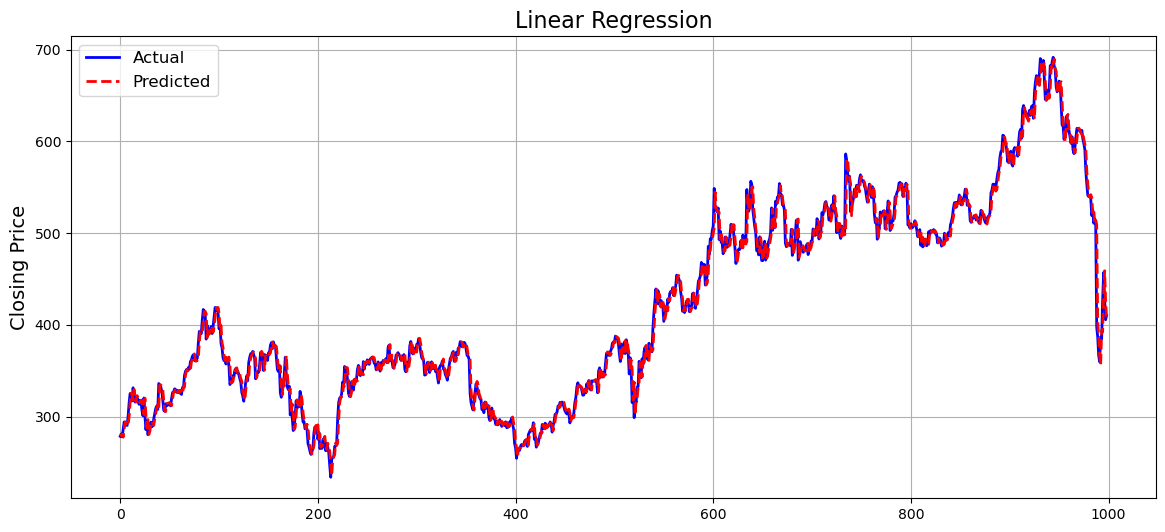

In [16]:
y_pred = lr_model.predict(X)
lr_metrics = calculate_metrics(y, y_pred)
print(y_pred)

print("Training Set Evaluation:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value}")

# Plot for Test Set
print("\n\nTest Set Actual vs Predicted:")
plot_actual_vs_predicted(y, y_pred, 'Linear Regression')

In [17]:
with open('model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)